<center><h1>Making Merger Tree from m3p output</h1></center>

`m3p_merger` is a library for producing merger trees and hence calculating the collapse redshift of halos simulated using the Peak Patch code m3p made by [C Behrens](https://github.com/cbehren). Results produced using this code have been published in my paper [Axion Miniclusters Made Easy](https://arxiv.org/abs/2006.08637).


In [1]:
import numpy as np
from m3p_merger import m3p_merger, utils
import matplotlib.pyplot as plt

### Define m3p data path

This directory should contain a folder of m3p input files called 'inputs' and a folder of m3p output files called 'axOut'.

We also define here the m3p inputs file for while we want to build our merger tree.

In [2]:
m3p_data_path = r"C:\Users\david\AxionData\PeakPatch\m3p_merger"
ppFile = "inputs.ax_jan5_stitched"

### Make list of all peaks
MakePeakList returns 1D array of length equal to the number of redshift outputs and the comoving boxsize. Each element of the array is an additional array of all of the peak properties in *Lagrangian* (unperturbed) coordinates for a given redshift output.

Each of these nested arrays stores the (x, y, z) coordinates [cMpc], radius [cMpc] and mass [Msol] of each peak. It therefore has a (5, N) shape where N is the number of peaks at this snapshot. 

For example: `peak_list[10][:,145]` will return the properties (x, y, z, radius, mass) for the 145th halo in the 10th redshift snapshot.

In [3]:
p = utils.ParamsFile(m3p_data_path + "\inputs/" + ppFile)
redshifts = p["redshifts"] 

peak_list, boxsize = m3p_merger.MakePeakList(ppFile, m3p_data_path, printOutput = True)

	Loading file (100 of 100): C:\Users\david\AxionData\PeakPatch\m3p_merger/axOut/jan5/jan5_stitched_final_halos_99.hdf5


## Num halo check

We see that, as expected, the number of halos begins very small then rises as linearly evolved overdensities grow and the collapse threshold falls. The number of halos peaks at around matter-radiation equality and then falls again as these halos merge together into a smaller number of larger final halos.

Text(0, 0.5, 'Number of halos')

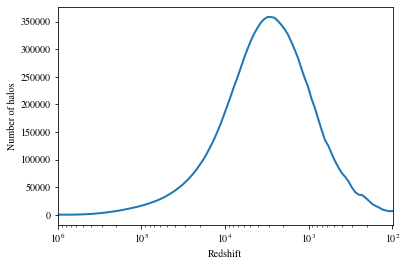

In [4]:
# Calculate number of peaks at each redshift
numHalos = [len(peak_list[i][0]) for i in range(len(peak_list))]

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.semilogx(redshifts, numHalos, lw = 2)
plt.xlim([max(redshifts), min(redshifts)])
plt.xlabel("Redshift")
plt.ylabel("Number of halos")

### Total mass check

We could similarly choose to look at the total mass of collapsed objects in our box


Text(0, 0.5, 'Total Mass [$M_{\\odot}$]')

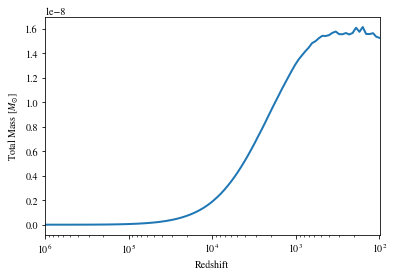

In [5]:
totalMass = [sum(peak_list[i][4,:]) for i in range(len(peak_list))]

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.semilogx(redshifts, totalMass, lw = 2)
plt.xlim([max(redshifts), min(redshifts)])
plt.xlabel("Redshift")
plt.ylabel("Total Mass [$M_{\odot}$]")

<h2><center>Building merger trees</center></h2> 

We construct merger trees from the peak list using `BuildMergerTree()`. 

This function defaults to calculating merger trees for all halos at the last snapshot. However, we can choose to produce one or more of a subset of merger trees by defining `final_halos_indicies` as shown below. 

`BuildMergerTree()` included the all regions overlapping with the final sphere. This, as shown later, makes the progenitor mass calculation much less "noisy" and therefore helps to improve the quality of the collapse redshift calculation. `BuildMergerTree_OLD()` instead takes the (slightly cruder) approach of inlcuding progenitor peaks *completely* if their centers are within the final sphere. 

In [6]:
out = m3p_merger.BuildMergerTree(peak_list, ppFile, m3p_data_path, final_halos_indicies = 4321)

### Plot all peaks on each other

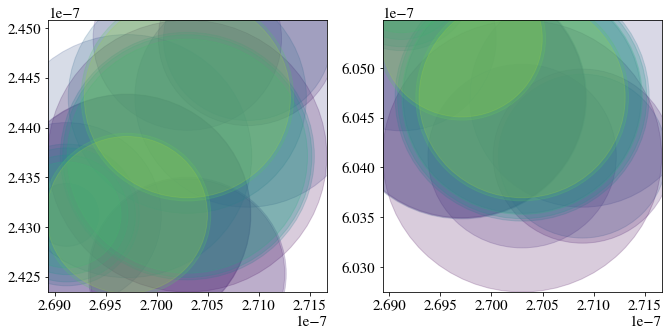

In [7]:
skip = 3
fig = m3p_merger.plotMergerPatches(out[0][::skip], ppFile, m3p_data_path, cmap = "viridis")
fig.patch.set_facecolor('white')

### Plot merger tree

There are many optional input variables to change the appearance of the merger tree.

earliest redshift = 482.0


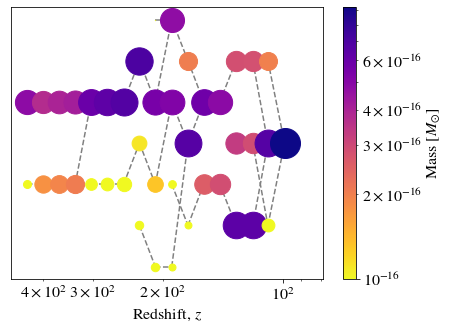

In [8]:
# Choose number of steps to miss in plotting (useful for very complex trees)
skip = 2
fig = m3p_merger.plotMergerTree(out[0][::skip], ppFile, m3p_data_path, font_size = 16, log = True,
                              colorbar=True, colorbar_title = "Mass [$M_{\odot}$]", cmap = "plasma_r")
fig.patch.set_facecolor('white')

<h2><center>Calculating collapse redshifts</center></h2> 

NFW defined the collapse redshift of a halo to be the redshift at which half of the final mass $M_{final}$ is contained within progenitor of mass greater than $fM_{final}$ where $f$ is some fraction.

This is the method used with `FindCollapseRedshift()`. This function gives both the calculated collapse redshift from an inputted merger tree and also the total mass over time. 

Below we see a comparison of `BuildMergerTree_OLD()` and `BuildMergerTree()`. Given that the two methods have the same final mass _by definition_ we see the issue with the old method.

Done.
method 1: z_col=9.26e+02
method 2: z_col=6.38e+02


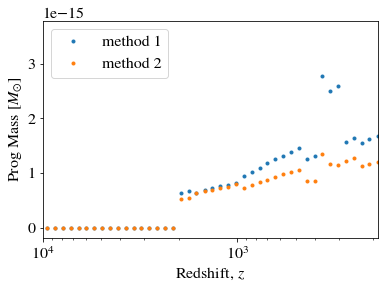

In [9]:
ppFile = "inputs.ax_jan5_stitched"

halo_index = 4321

f = 0.01

peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile, m3p_data_path, startIndex = 0, massType = "unstripped")

labels = ["method 1", "method 2"]
fig = plt.figure()
fig.patch.set_facecolor('white')
for i, func in enumerate([m3p_merger.BuildMergerTree_OLD, m3p_merger.BuildMergerTree]):
    out = func(peak_list_main, ppFile, m3p_data_path, final_halos_indicies = halo_index)
    zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile, m3p_data_path, startIndex = 0, interp = "None")
    plt.semilogx(z, ProgMass, ".", ms=6, label = labels[i])
    
    print("{}: z_col={:.3}".format(labels[i], zCol))

plt.legend(loc=2);
plt.xlim(max(z), min(z));
plt.ylabel("Prog Mass [$M_{\odot}$]");
plt.xlabel("Redshift, $z$");
plt.xlim(1e4, 190);

### Calculating collapse redshifts of all halos

An example script for calculating the collapse redshifts of all halos in the final redshift snapshot is shown in `CalcColl.py`.